In [1]:
import numpy as np
import pandas as pd
from skimage import io
import cv2
import random
import os
import shutil
import glob
import matplotlib.pyplot as plt

# Loading the model

In [2]:
from ultralytics import YOLO

model = YOLO('YoloModelFiles/best.pt')  # load a pretrained model (recommended for training)

# Make Predictions

## loading images for testing

In [29]:
path = 'Images/Testing'
images = glob.glob( path + '/*.jpg')

## plotting the images predictions

In [4]:
import random
import cv2
import matplotlib.pyplot as plt

def visualize_results(images, model):
    """
    Visualizes the results of the wooden box detection model on a set of images.

    Args:
        images (list): A list of image file paths.
        model: The wooden box detection model.

    Returns:
        None
    """

    plt.figure(figsize=(15, 15))
    for plot_index in range(9):
        index = random.randint(0, len(images) - 1)
        image_path = images[index]
        img = cv2.imread(image_path)
        results = model(image_path, conf=0.95)[0]

        plt.subplot(3, 3, plot_index + 1)
        plt.imshow(results.plot())
        plt.axis('off')


image 1/1 c:\Users\LENOVO\Desktop\Depth Measurement\Images\Testing\photo_2023-12-13_05-43-20.jpg: 640x640 1 Box, 212.6ms
Speed: 8.8ms preprocess, 212.6ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\LENOVO\Desktop\Depth Measurement\Images\Testing\photo_2023-12-13_05-46-51.jpg: 640x480 1 Box, 141.8ms
Speed: 2.2ms preprocess, 141.8ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 c:\Users\LENOVO\Desktop\Depth Measurement\Images\Testing\photo_2023-12-13_05-43-29.jpg: 640x640 1 Box, 180.1ms
Speed: 10.0ms preprocess, 180.1ms inference, 14.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\LENOVO\Desktop\Depth Measurement\Images\Testing\photo_2023-12-13_05-43-29.jpg: 640x640 1 Box, 180.9ms
Speed: 4.0ms preprocess, 180.9ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\LENOVO\Desktop\Depth Measurement\Images\Testing\photo_2023-12-13_05-43-29.jpg: 640x640 1 Box, 183

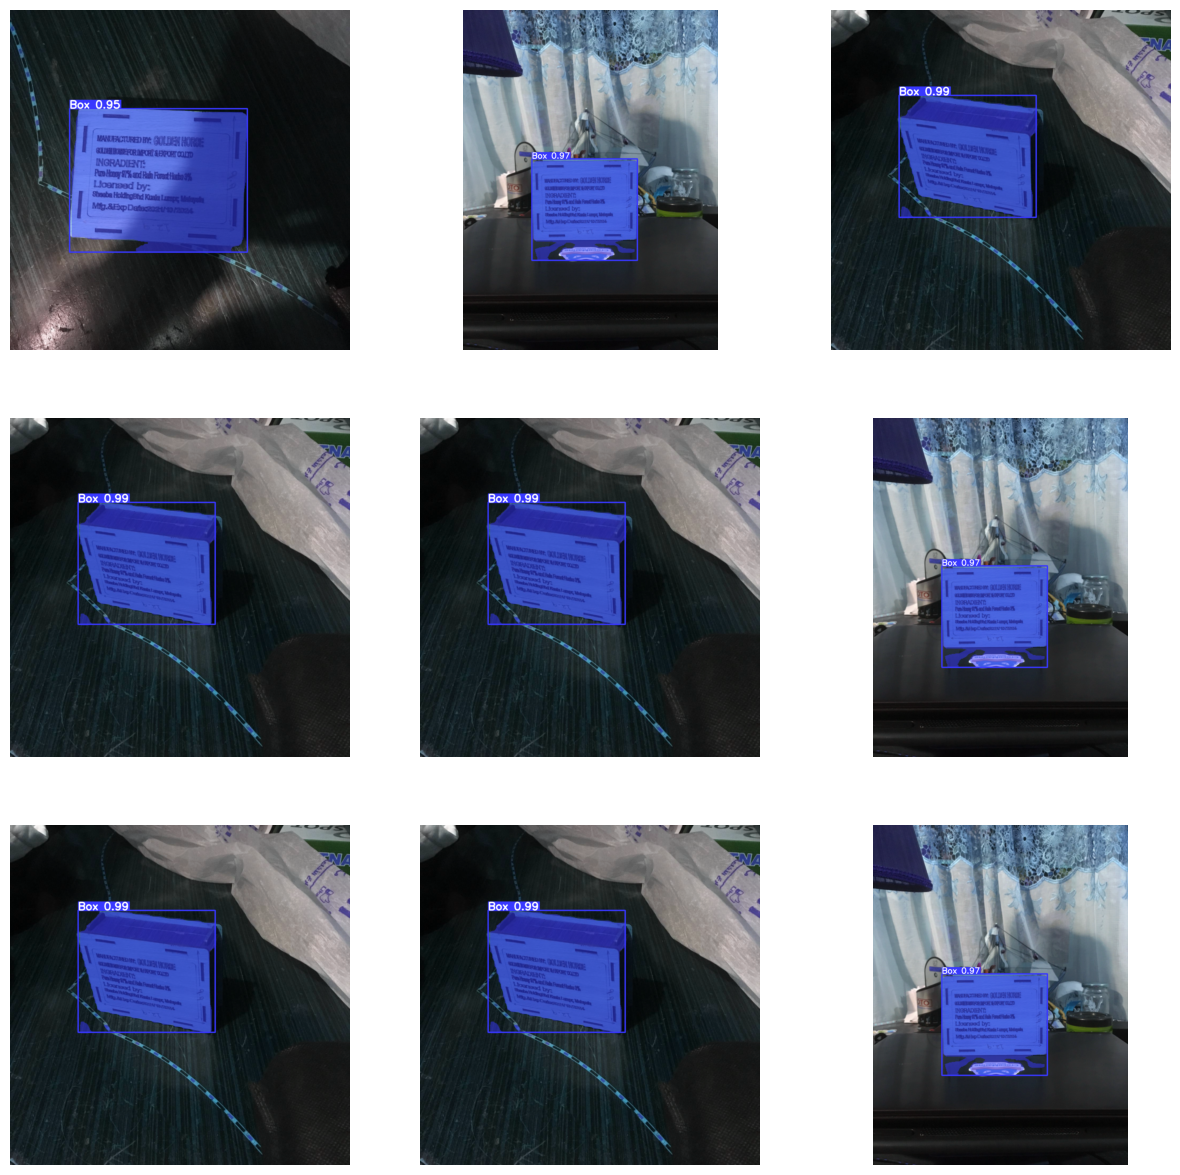

In [32]:
visualize_results(images, model)

# Getting Box Corners

In [40]:
path = 'Images'
images = glob.glob( path + '/*.jpg')
image_path = images[4]

In [7]:
def GetMask(image_path, 
            model_path= 'c:/Users/LENOVO/Desktop/Depth Measurement/YoloModelFiles/best.pt'):
    '''
    this function returns a list of binary masks using yolo segmentation

    '''

    model = YOLO(model_path)
    results = model(image_path, conf = 0.95)[0]
    masks = results.masks.data
    
    return np.array(masks, dtype='uint8')

In [41]:
mask = GetMask(image_path)


image 1/1 c:\Users\LENOVO\Desktop\Depth Measurement\Images\image2.jpg: 640x640 1 Box, 191.7ms
Speed: 2.6ms preprocess, 191.7ms inference, 12.7ms postprocess per image at shape (1, 3, 640, 640)


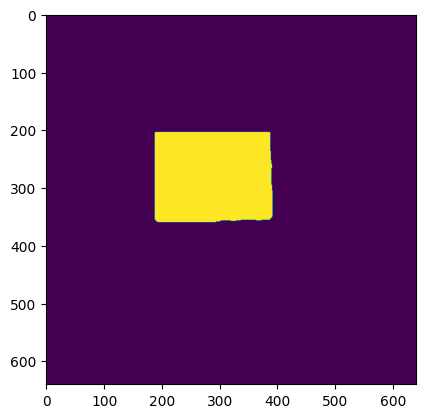

In [42]:
plt.imshow(mask[0])

In [10]:
def GetCorners(mask):
    '''
    this function returns the detected corners using harris corner detection on a binary mask
    '''

    grayfloatimg = np.float32(mask)
    rscores = cv2.cornerHarris(grayfloatimg, 8, 5, 0.07)

    rscores = cv2.dilate(rscores,None)
    threshold = 0.01*rscores.max()

    return (rscores>threshold), rscores

image = cv2.imread(image_path)
image = cv2.resize(image, (640,640))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

corners, rscores = GetCorners(mask[0])
img = image.copy() 
img[corners] = [0,255,0]

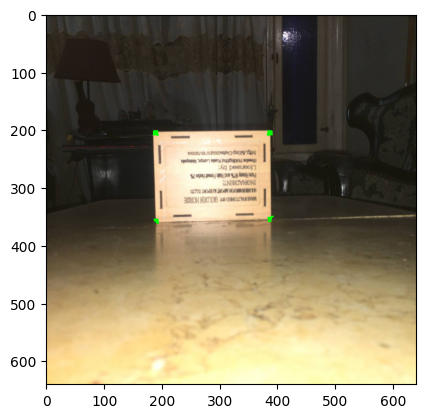

In [11]:
plt.imshow(img)

In [12]:
def GetMinBBox(mask):
    '''
    this function returns the minimum (rotated) box corners using a binary mask
    '''
    contours, hierarchy  = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = tuple(sorted(contours, key=cv2.contourArea , reverse=True))

    rect = cv2.minAreaRect(contours[0])
    box = np.intp(cv2.boxPoints(rect))
    return box

box = GetMinBBox(mask[0])
im = image.copy()

im = cv2.drawContours(im, [box], -1, (0, 255, 0), 1)

(-0.5, 639.5, 639.5, -0.5)

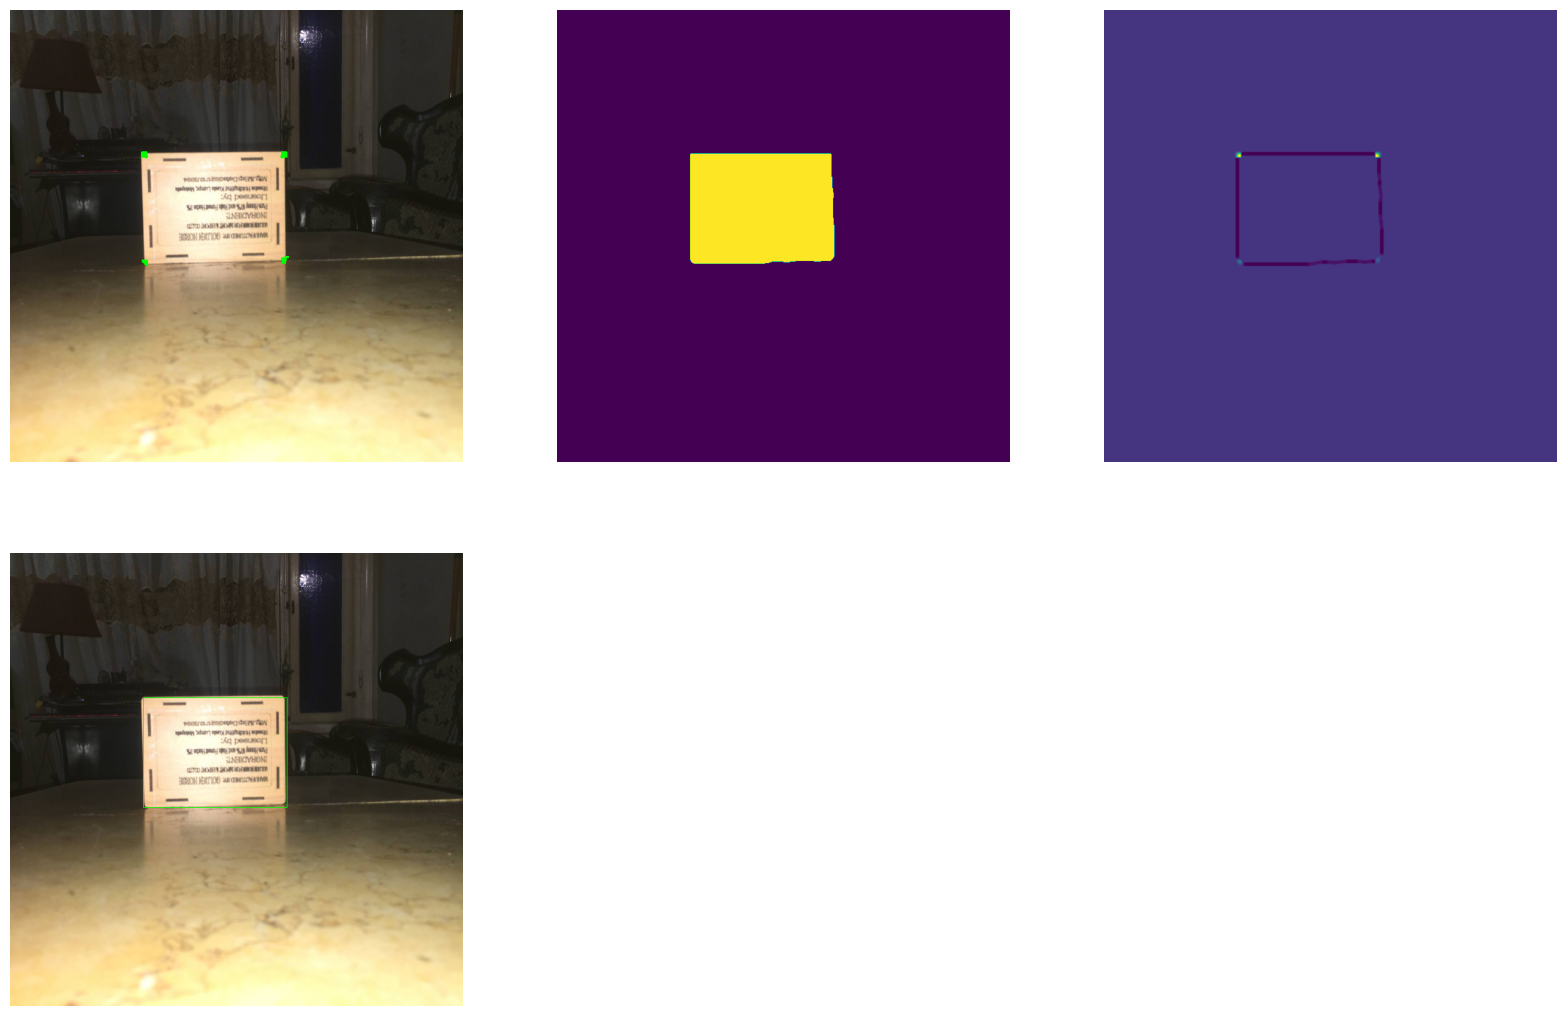

In [13]:
plt.figure(figsize=(20,20))

plt.subplot(3,3, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(3,3, 2)
plt.imshow(mask[0])
plt.axis('off')

plt.subplot(3,3, 3)
plt.imshow(rscores)
plt.axis('off')

plt.subplot(3,3, 4)
plt.imshow(im)
plt.axis('off')

# Testing the package

In [65]:
from WoodenBox_detector import WoodenBox
path = 'Images/measured_images'
images = glob.glob(path + '/*.jpg')
image_path = images[4]
image = cv2.imread(image_path)
image = cv2.resize(image, (640,640))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

wooden = WoodenBox()
wooden.image = image
bbox = wooden.run()
if type(bbox) != type(None) :
    im = cv2.drawContours(image, [bbox], -1, (0, 255, 0), 1)

In [66]:
wooden.sucess

True

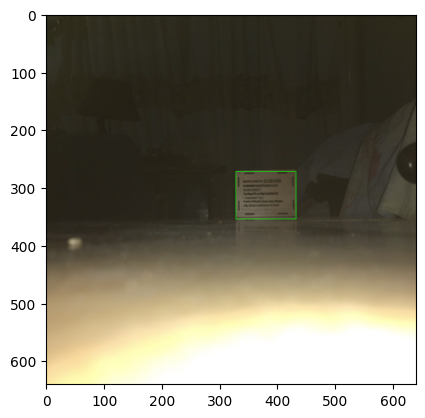

In [61]:
plt.imshow(image)

In [25]:
import numpy as np

def calculate_distance(bbox):
    """
    Calculates the distance based on the given bounding box.

    Parameters:
    bbox (tuple): A tuple containing the bounding box coordinates.

    Returns:
    float: The calculated distance.
    """

    y = [90, 30, 20] # collected data by moving the box to multiple different distances
    x = [107, 231, 455]

    coefficients = np.polyfit(x, y, 3)
    poly_function = np.poly1d(coefficients)
    dist = poly_function((bbox[1] - bbox[0])[0])

    return dist

In [71]:
measured_distance = calculate_distance(bbox)
measured_distance

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16608\4091791218.py:1: RankWarning: Polyfit may be poorly conditioned
  measured_distance = calculate_distance(bbox)


91.65901570225179

In [73]:
import os
actal_distance = os.path.split(image_path)[1].split('.')[0]

In [75]:
print(f"Measured Distance   : {measured_distance:.4f} cm")
print(f"Actual Distance     : {actal_distance} cm")

Measured Distance   : 91.6590 cm
Actual Distance     : 90 cm
